In [89]:
from collections import namedtuple
from itertools import starmap
from matplotlib import ticker, gridspec
from matplotlib.figure import Figure
from matplotlib.axis import Axis
from typing import cast, Unpack
from math import ceil

import json
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys

from collections import defaultdict

In [90]:
# Allow imports from parent folder
sys.path.append("..")

from compute_structures import *
from error_functions import mean_squared_error as MSE
from error_functions import root_mean_squared_error as RMSE
from error_functions import mean_absolute_relative_error as MARE
from error_functions import symmetric_mean_absolute_relative_error as SMARE
from error_functions import symmetric_mean_absolute_relative_error_alt as SMARE_alt
from error_functions import mean_my_error as mean_my_err
from error_functions import mean_log_relative_error as mean_log_err

from error_functions import absolute_error as abs_err
from error_functions import relative_error as rel_err
from error_functions import symmetric_relative_error as sym_rel_err
from error_functions import symmetric_relative_error_alt as sym_rel_err_alt
from error_functions import log_relative_error as log_rel_err
from error_functions import log_absolute_error as log_abs_err
from error_functions import squared_error as sq_err
from error_functions import my_error as my_err

In [91]:
stats_folder = "../stats/"
figures_folder = "../figures/"


in_file = "listings"

In [92]:

def savefig(fig: Figure, name: str, **kwargs):
    full_name = in_file + "_" + name + ".pdf"
    fig.savefig(figures_folder + full_name, bbox_inches="tight", **kwargs)

## Setting Up the Data

In [93]:
from typing import Literal, NamedTuple, NotRequired

class OverrideSetting(TypedDict):
    stats_type: StatType
    prune_strats: tuple[PruneStrat]
    sampling_rate: float
    num_histogram_buckets: NotRequired[int]
    prune_params: dict[str, Any]

class DataRow(NamedTuple):
    override_settings: OverrideSetting
    error_data: list[float]
    actual_data: dict[str, tuple[list[int], list[int]]]
    meta_data: dict

Data = list[DataRow]

In [94]:
stats_data_path = stats_folder + in_file + "_analysis.pickle"
with open(stats_data_path, "rb") as f:
    data = pickle.load(f)

# Process the data to make it easier to work with
for i in range(len(data)):
    row = data[i]
    # Make lists into tuples so they can be dict keys
    ov_sets = row[0]
    if "prune_strats" in ov_sets:
        ov_sets["prune_strats"] = tuple(ov_sets["prune_strats"])

    # Split truth and estimate into separate lists, instead of keeping them as pairs
    actual_data = row[2]
    for k, v in actual_data.items():
        actual_data[k] = tuple(zip(*v))

    # Turn the row into a DataRow
    data[i] = DataRow(*row)

data = cast(Data, data)

In [95]:
override_settings, error_data, actual_data, meta_data = zip(*data)

# Allow access to results data using string of override settings used when collecting the results data
data_by_settings = {str(row[0]): row[1:] for row in data}

def group_data_by(group_val_key: Literal["prune_strats", "stats_type", "sampling_rate"]) -> dict[OverrideSetting, Data]:
    grouped = defaultdict(list)
    for row in data:
        key_val = row.override_settings[group_val_key]
        grouped[key_val].append(row)

    return grouped

data_by_stats = group_data_by("stats_type")
data_by_pruning = group_data_by("prune_strats")
data_by_sampling = group_data_by("sampling_rate")

In [96]:
# None => allow only where key is not defined
# '*' => allow any value
# <value> => matching value
# ! Does not handle when value is None, but I don't think that can every happen here
class OverrideSettingKwargs(OverrideSetting, total=False): pass
def get_by_settings(**kwargs: Unpack[OverrideSettingKwargs]) -> Data:
    assert all(k in OverrideSetting.__annotations__ for k in kwargs), f"Settings key was misspelled! {list(kwargs.keys())}"

    def settings_filter(data_row: DataRow):
        ov_sets = data_row.override_settings
        for key, val in kwargs.items():
            if val != '*':
                if val is None and key in ov_sets:
                    return False
                if key not in ov_sets or ov_sets[key] != val:
                    if key in ov_sets:
                        assert type(val) == type(ov_sets[key]), f"{val} vs. {ov_sets[key]}"
                    return False
        return True

    return list(filter(settings_filter, data))

## Visualization Functions

In [97]:
def translate_label(label: str) -> str:
    return (
        {
            "eq": "EQ (=)",
            "lt": "LT (<)",
            "gt": "GT (>)",
            "is_null": "is null",
            "is_not_null": "is not null",
            "memberof": "mem",
            "contains": "con",
            "overlaps": "int",
        } | {
            str(stype): str(stype).split(".")[1]  for stype in StatType
        }
    ).get(label, label)

def pretty_err_func(errfunc) -> str:
    if errfunc == log_rel_err:
        return "Log Relative Error " + r'[$\log(\frac{C_{est}}{C_{true}})$]'
    if errfunc == sym_rel_err:
        return "Symmetric Relative Error " + r'[$\frac{|C_{true} - C_{est}|}{|C_{true} + C_{est}|})$]'

    return errfunc.__name__
    
def format_title(stats_type=None, num_hist_bucks=None, sampling_rate=None, prune_strat=None, 
                 min_freq_threshold=None, max_no_paths_threshold=None,
                 short=False, short_hist=False):
    out = ""
    if stats_type:
        stat_name = str(stats_type).split(".")[1]
        if short:
            out += "".join([s[0] for s in stat_name.split("_")])
        elif short_hist and num_hist_bucks:
            out += stat_name[:4]
        elif short_hist and stats_type == StatType.NDV_WITH_MODE:
            out += "NDV_MODE"
        else:
            out += stat_name

        if num_hist_bucks:
            out += f"[{num_hist_bucks}]"

        if sampling_rate is not None:
            out += f" × {(1 - sampling_rate):.2f}"

    if prune_strat:
        if out != "":
            out += ": "

        strat_name = str(prune_strat).split(".")[1].split(":")[0]
        out += strat_name

        if min_freq_threshold:
            out += f"$>_f$ {min_freq_threshold:.3f}"

        if max_no_paths_threshold:
            out += f"$\in$ top {max_no_paths_threshold}"

    if sampling_rate is not None:
        return f"{1 - sampling_rate:.2f} Sampling Rate"

    return out

In [99]:
PlotDict = dict[str, pd.Series]

def _ax_boxplot(ax: Axis, datas: list[list[float]], x_labels=None, title=None, ylim=None, is_log=True, showfliers=False, violin=False, xlabel=None, ylabel=None):
    x_labels = list(map(translate_label, x_labels))

    if violin:
        for i, s in enumerate(datas):
            if all(v == 0 for v in s):
                datas[i] = pd.Series([-0.000001, 0.00001])
        ax.violinplot(datas, showmedians=True, showextrema=True)
        plt.xticks(ticks=plt.xticks()[0], labels=[""] + x_labels + [""])
    else:
        ax.boxplot(
            datas, 
            labels=x_labels, 
            showfliers=showfliers, 
            medianprops={"linewidth": 2},
            flierprops={"marker": ".", },
        )


    ax.set_title(title)
    ax.set(ylim=ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if is_log:
        # Make sure there are no more ticks than unique values on the y axis ticks
        bottom = min(plt.ylim()[0], -1)
        top = max(plt.ylim()[1], 1)
        ax.set(ylim=(bottom, top))
        y_tick_range = top - bottom
        if y_tick_range >= 3:
            plt.locator_params(nbins=top - bottom, axis='y')
            ax.yaxis.set_major_formatter(lambda x, _pos: f"$10^{{{int(x)}}}$")
        else:
            ax.yaxis.set_major_formatter(lambda x, _pos: f"${10**x:.2f}$")
            ax.yaxis.set_major_formatter(lambda x, _pos: f"$10^{{{x:.2f}}}$")
    
    ax.grid(visible=True, linewidth=0.5)

def boxplot(error_collection: PlotDict, title=None, ylim=None, **kwargs):  
    errors = list(error_collection.values())
    x_labels = list(error_collection.keys())

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    _ax_boxplot(ax, errors, x_labels=x_labels, title=title, ylim=ylim, **kwargs)

    plt.show()

    return fig


def multiple_boxplots(datas: list[PlotDict], titles=[], layout=None, ylim=None, shareax=False, xlabel=None, ylabel=None, figsize=None, **kwargs):
    if titles:
        assert len(titles) == len(datas)

    if shareax:
        assert ylim, "TODO: Programmatically set ylim to widest of all subplots"

    n_rows, n_cols = layout if layout else (ceil(len(datas)/3), 3)

        
    num_vertical_items = len(datas[0])
    fig = plt.figure(tight_layout=True, figsize=figsize or [num_vertical_items*3, 9])  # default figsize=[6.4, 4.8] ([width, height] in inches)
    gs = gridspec.GridSpec(n_rows, n_cols)

    if shareax:
        fig.supxlabel(xlabel)
        fig.supylabel(ylabel)
    else: 
        kwargs.update({"xlabel": xlabel, "ylabel": ylabel})

    for grid_idx, err_coll in enumerate(datas):
        grid_item = gs[grid_idx//n_cols, grid_idx%n_cols]

        ax = fig.add_subplot(grid_item)
        if shareax:
            # if grid_idx%2 != 0:
            if grid_idx%n_cols != 0:
                plt.setp(ax.get_yticklabels(), visible=False)

            if grid_idx//n_cols < n_rows-1:
                plt.setp(ax.get_xticklabels(), visible=False)

        errors = list(err_coll.values())
        x_labels = list(err_coll.keys())
        _ax_boxplot(ax, errors, x_labels=x_labels, title=titles[grid_idx] if titles else None, ylim=ylim, **kwargs)

    
    return fig

## Plotting ALL v ALL

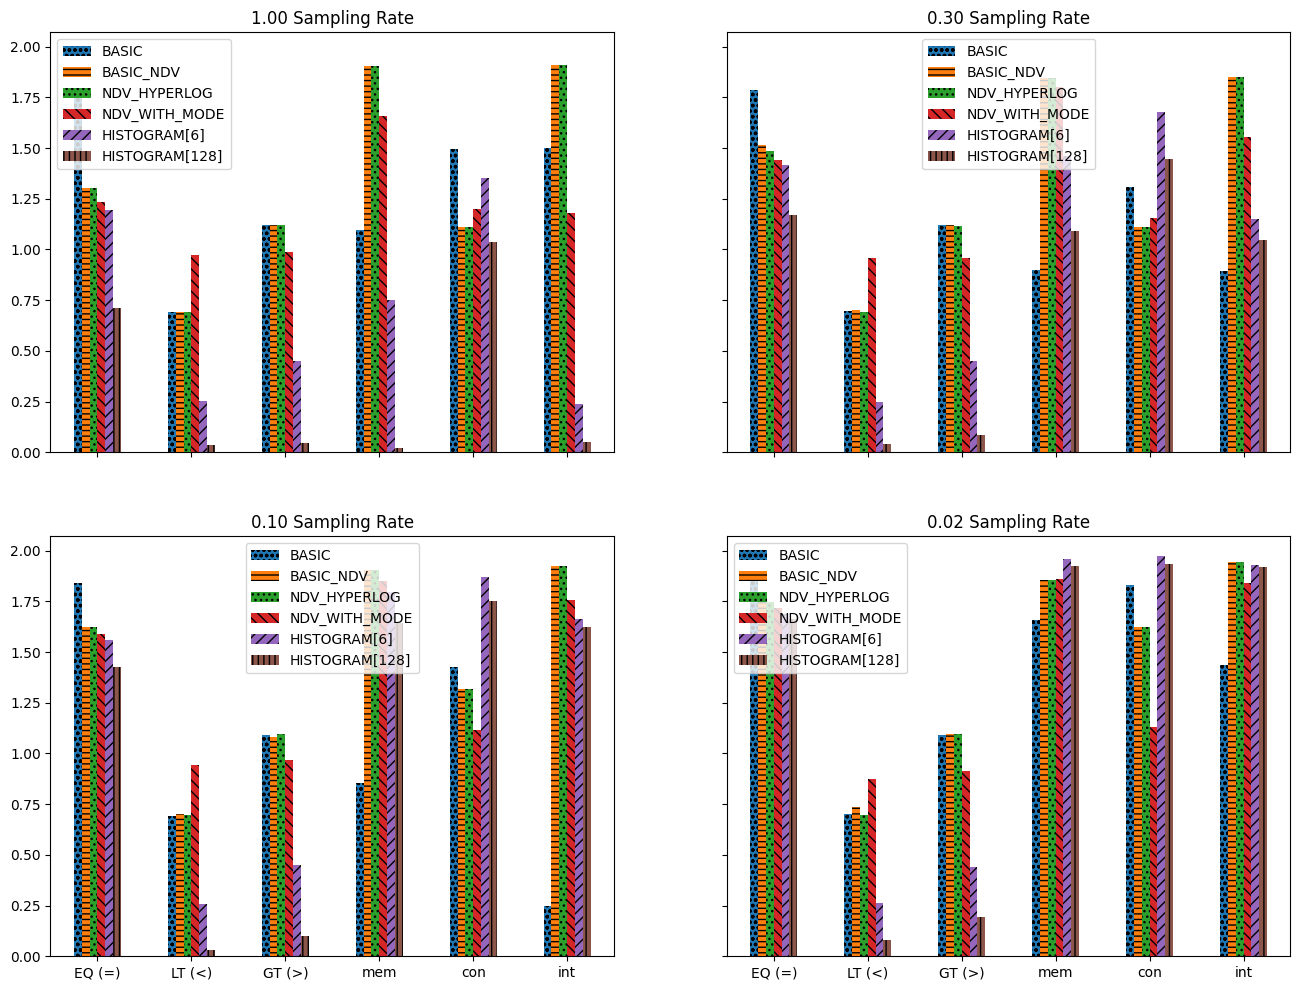

In [100]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(16, 12))

for i, sr in enumerate((0.0, 0.7, 0.9, 0.98)):
    all_no_pruning = [
        drow for drow in
        get_by_settings(prune_strats=tuple(), sampling_rate=sr)
        if (
            "num_histogram_buckets" not in drow.override_settings or 
            drow.override_settings["num_histogram_buckets"] in (6, 128)
        )
    ]

    result = {}
    for config_case in all_no_pruning:
        test_data = config_case.actual_data
        
        errors = {}
        for operator, op_results in test_data.items():
            if not op_results: continue
            if operator in ("exists", "is_null", "is_not_null"): continue
            errors[translate_label(operator)] = SMARE(*op_results)

        results_key = format_title(
            stats_type=config_case.override_settings["stats_type"],
            num_hist_bucks=config_case.override_settings.get("num_histogram_buckets"),
        )
        result[results_key] = errors


    df = pd.DataFrame(result)
    ax = df.plot(
        ax=axes[i//2, i%2],
        kind="bar", 
        title=format_title(sampling_rate=sr),
        rot=0,
    )


    # Thank you to: https://stackoverflow.com/a/22836353
    bars = ax.patches
    colors = set(r.get_facecolor() for r in bars)
    hatches = ("...", "///", "ooo", "\\\\\\",  "---", "|||", "***", "xxx")
    color_to_hatch = {c: h for c, h in zip(colors, hatches)}

    for bar in bars:
        bar.set_hatch(color_to_hatch[bar.get_facecolor()])

    ax.legend()

# savefig(fig, "all_estimate_error_compared_per_sampling_rate")

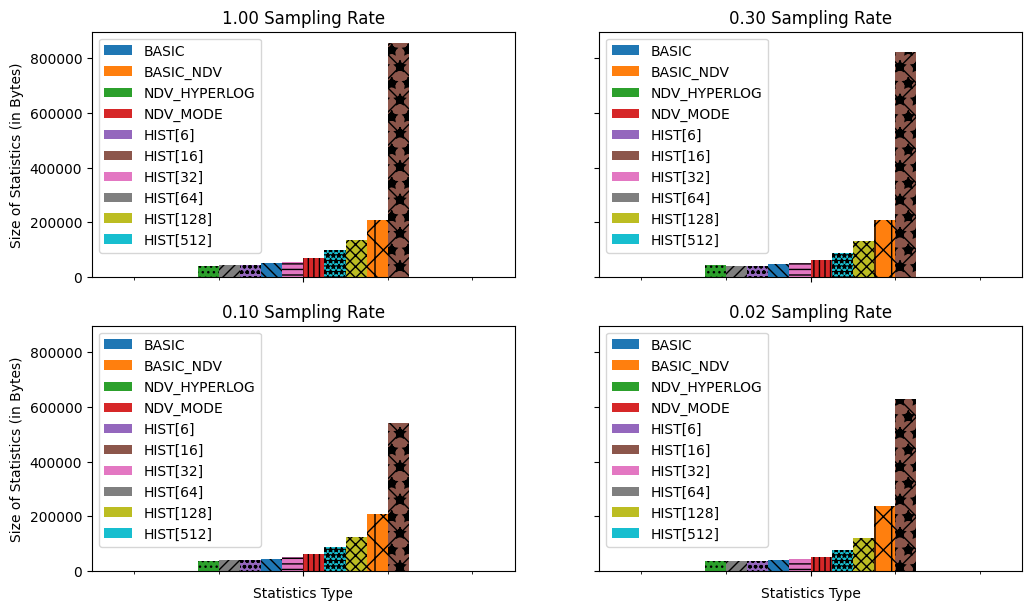

In [101]:



fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12, 7))
for i, sr in enumerate((0.0, 0.7, 0.9, 0.98)):
    all_no_pruning = [
        drow for drow in
        get_by_settings(prune_strats=tuple(), sampling_rate=sr)
        # if (
        #     "num_histogram_buckets" not in drow.override_settings or 
        #     drow.override_settings["num_histogram_buckets"] in (6, 128)
        # )
    ]

    result = {}
    for rowdata in sorted(all_no_pruning, key=lambda r: r.override_settings["stats_type"].value):
        results_key = format_title(
            stats_type=rowdata.override_settings["stats_type"],
            num_hist_bucks=rowdata.override_settings.get("num_histogram_buckets"),
            short_hist=True
        )
        result[results_key] = {"": rowdata.meta_data["stats_size"]}

        # result[results_key] = {"": rowdata.meta_data["stats_creation_max_mem_use"]}
        # result[results_key] = {"": rowdata.meta_data["time_taken"]}
        # all_of_type = [
        #     _rowdata.meta_data["time_taken"]
        #     for _rowdata in get_by_settings(sampling_rate=sr, stats_type=rowdata.override_settings["stats_type"])
        #     if _rowdata.override_settings.get("num_histogram_buckets") == rowdata.override_settings.get("num_histogram_buckets")
        # ]
        # averaged = sum(tt/len(all_of_type) for tt in all_of_type)
        # result[results_key] = {results_key: averaged}


    df = pd.DataFrame(result)
    ax = df.plot(
        ax=axes[i//2, i%2],
        kind="bar", 
        title=format_title(sampling_rate=sr),
        rot=30,
        xlabel="Statistics Type",
        ylabel="Size of Statistics (in Bytes)",
        # ylabel="Time to Collect Statistics (seconds)",
        # width = 5,
    )

    # Thank you to: https://stackoverflow.com/a/22836353
    bars = ax.patches
    colors = set(r.get_facecolor() for r in bars)
    hatches = ("...", "///", "ooo", "\\\\\\",  "---", "|||", "***", "xxx", "\\|/", "*xo", "-|-|")
    color_to_hatch = {c: h for c, h in zip(colors, hatches)}
    for bar, color in zip(bars, colors):
        bar.set_facecolor(color)
        bar.set_hatch(color_to_hatch[bar.get_facecolor()])
    
    # ax.legend().remove()

# # savefig(fig, "all_size_compared_per_sampling_rate")
# savefig(fig, "all_time_taken_compared_per_sampling_rate")

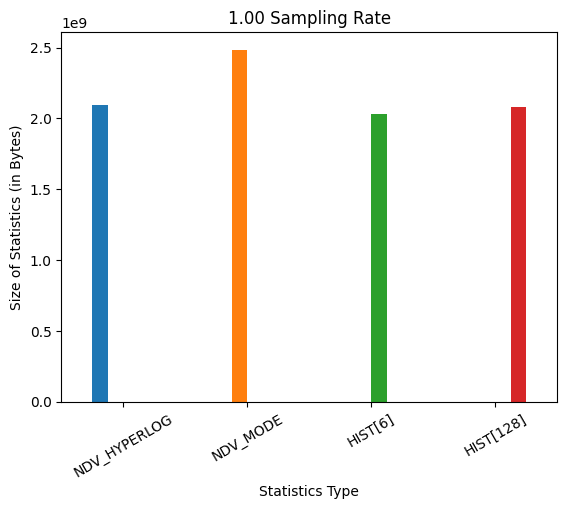

In [102]:
sr = 0.0


all_no_pruning = [
    drow for drow in
    get_by_settings(prune_strats=tuple(), sampling_rate=sr)
    if (drow.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV))
        and ("num_histogram_buckets" not in drow.override_settings or 
            drow.override_settings["num_histogram_buckets"] in (6, 128))
]

result = {}
for rowdata in sorted(all_no_pruning, key=lambda r: r.override_settings["stats_type"].value):
    results_key = format_title(
        stats_type=rowdata.override_settings["stats_type"],
        num_hist_bucks=rowdata.override_settings.get("num_histogram_buckets"),
        short_hist=True
    )
    result[results_key] = {"": rowdata.meta_data["stats_size"]}

    all_of_type = [
        _rowdata.meta_data["time_taken"]
        for _rowdata in get_by_settings(sampling_rate=sr, stats_type=rowdata.override_settings["stats_type"])
        if _rowdata.override_settings.get("num_histogram_buckets") == rowdata.override_settings.get("num_histogram_buckets")
    ]
    averaged = sum(tt/len(all_of_type) for tt in all_of_type)
    result[results_key] = {results_key: averaged}


df = pd.DataFrame(result)
ax = df.plot(
    kind="bar", 
    title=format_title(sampling_rate=sr),
    rot=30,
    xlabel="Statistics Type",
    ylabel="Size of Statistics (in Bytes)",
    # ylabel="Time to Collect Statistics (seconds)",
    # width = 5,
)
    
ax.legend().remove()

# # savefig(fig, "all_size_compared_per_sampling_rate")
# savefig(fig, "all_time_taken_compared_per_sampling_rate")

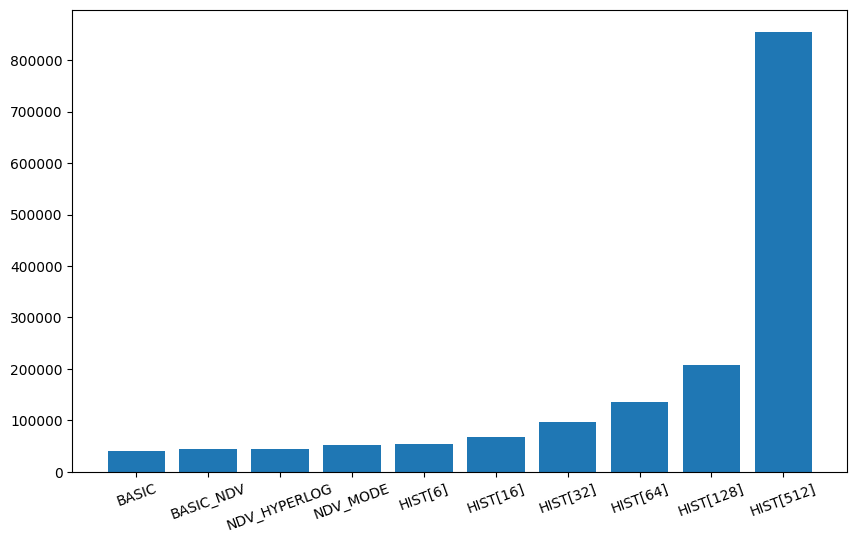

In [103]:
all_no_pruning = get_by_settings(prune_strats=tuple(), sampling_rate=0.0)
result = {}
for rowdata in all_no_pruning:
    results_key = format_title(
        stats_type=rowdata.override_settings["stats_type"],
        num_hist_bucks=rowdata.override_settings.get("num_histogram_buckets"),
        short_hist=True
    )
    # result[results_key] = {results_key: rowdata.meta_data["stats_size"]}
    result[results_key] = rowdata.meta_data["stats_size"]


# df = pd.DataFrame(result)
# ax = df.plot(
#     kind="bar", 
#     title="Size per statistic",
#     rot=30,
#     xlabel="Statistics Type",
#     ylabel="Bytes",
#     figsize=(10, 6),
# )

fig = plt.figure(figsize=(10, 6))
plt.subplot(1,1,1)
plt.bar(result.keys(), result.values(), )
plt.xticks(rotation=20)
plt.show()
savefig(fig, "simple_all_type_sizes_no_sampling")

### Plotting the different error measurements [histogram(*), K sampling, no pruning]: equality

This can be used to show the impact that increasing the number of histogram buckest has.

In [104]:
# Histograms only
# hist_no_sampling_no_pruning = get_by_settings(stats_type=StatType.HISTOGRAM, prune_strats=tuple(), sampling_rate=0.9)

# All statistics types -- multiple histograms
hist_no_sampling_no_pruning = get_by_settings(prune_strats=tuple(), sampling_rate=0.9)

In [105]:
error_funcs = [
    MSE, RMSE, MARE, SMARE, SMARE_alt, mean_my_err, mean_log_err
]
for err_func in error_funcs:
    result = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        errors = {}
        for operator, op_results in test_data.items():
            if not op_results: continue
            
            errors[operator] = err_func(*op_results)

        results_key = format_title(
            stats_type=config_case.override_settings["stats_type"],
            num_hist_bucks=config_case.override_settings.get("num_histogram_buckets"),
            short=True,
        )
        result[results_key] = errors


    df = pd.DataFrame(result)
    # df.plot(title=err_func.__name__)


error_funcs = [
    sym_rel_err, log_rel_err, 
    # rel_err, my_err, sym_rel_err_alt
    # abs_err, log_abs_err, sq_err,  # <-- bad error measures
]
for err_func in error_funcs:
    results = {}
    for config_case in hist_no_sampling_no_pruning:
        test_data = config_case.actual_data
        
        op_results = test_data["eq"]
        errors = pd.Series(list(starmap(err_func, zip(*op_results))))
        # Outlier removal
        # q = errors.quantile(0.995)
        # errors = errors[errors < q]

        results_key = format_title(
            stats_type=config_case.override_settings["stats_type"],
            num_hist_bucks=config_case.override_settings.get("num_histogram_buckets"),
            short=True,
        )
        results[results_key] = errors


    # fig = boxplot(
    #     results,
    #     title=pretty_err_func(err_func),
    #     is_log=(err_func == log_rel_err),
    #     showfliers=True
    # )
    # savefig(fig, err_func.__name__ + "_eq_box_plot")

    # df = pd.DataFrame(results)
    # ax = df.plot(
    #         kind="box", 
    #         title=pretty_err_func(err_func), 
    #         grid={"visible": True}, 
    #         flierprops={"marker": ".", },
    #         # showfliers=False,
    #         figsize=(2*len(results), 6)
    # )
    # fig = ax.get_figure()
    # fig.savefig()

### Plotting the operators against each other with log relative error

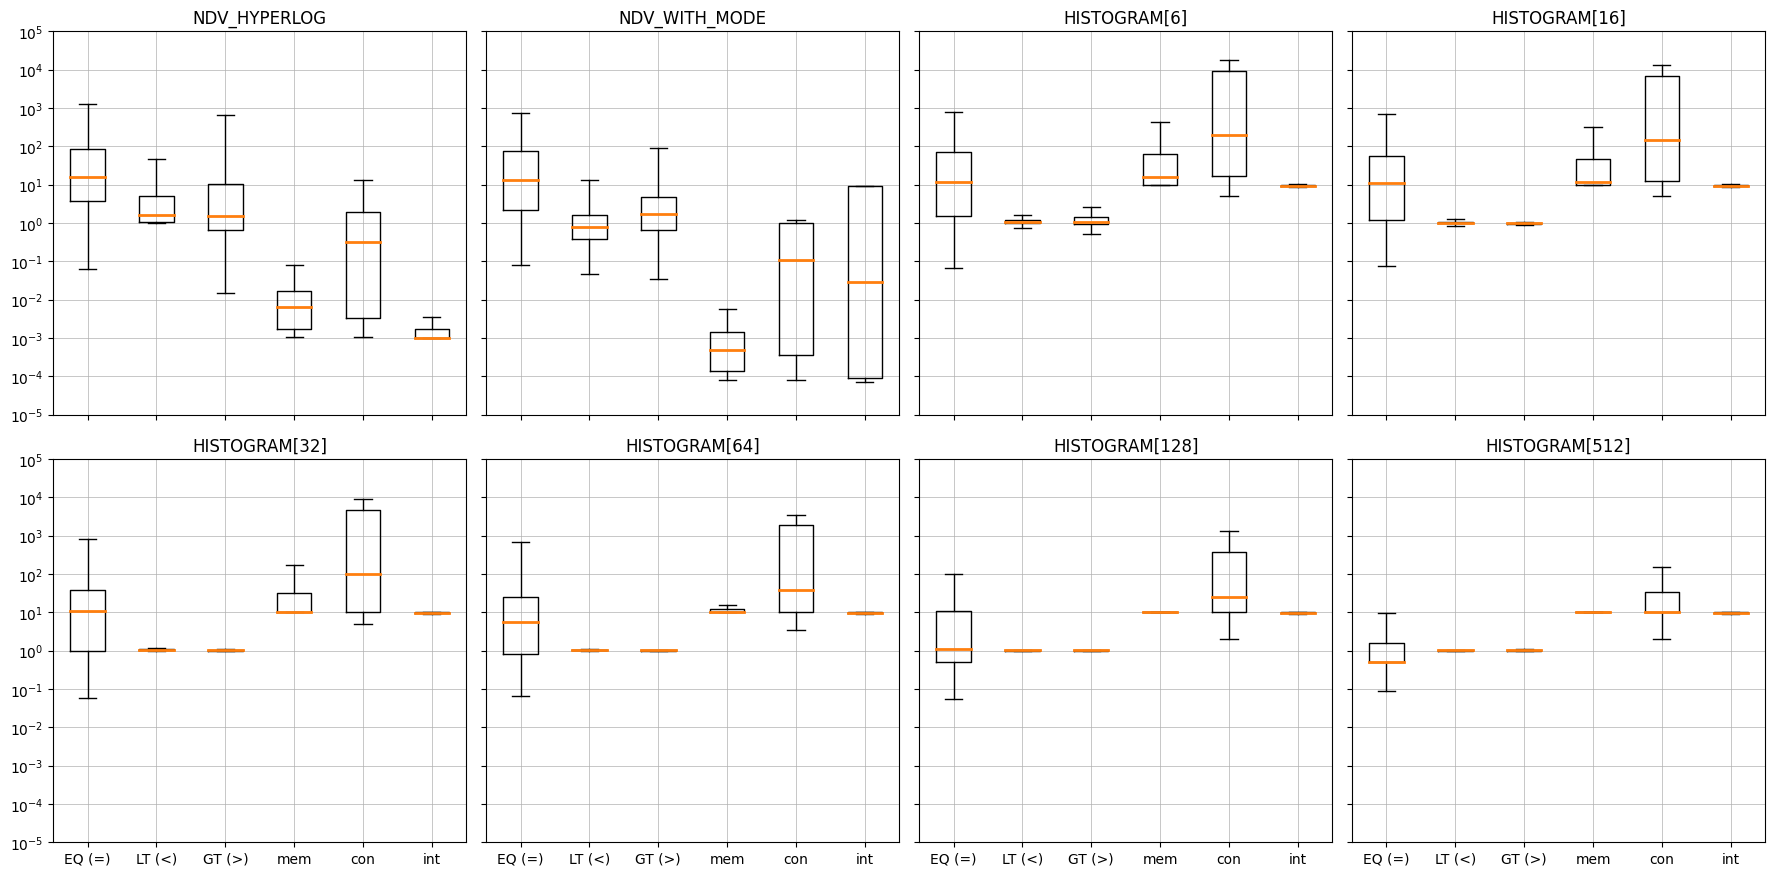

In [106]:
sr = 0.9
data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=sr)

data_rows = [
    dr for dr in data_rows
    if dr.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV)
]

all_errs = []
titles = []
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue
        
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        q = err_series.quantile(0.999)
        err_series = err_series[err_series < q]
        q = err_series.quantile(0.001)
        err_series = err_series[err_series > q]
        
        collected_errors[operator] = err_series

    all_errs.append(collected_errors)
    ov_sets = datarow.override_settings
    titles.append(format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets")))

fig = multiple_boxplots(all_errs, titles, ylim=(-5, 5), layout=(2, 4), shareax=True)

# savefig(fig, "all_boxplots_per_operator_max_sampling")
savefig(fig, "all_violinplots_per_operator_sampling_" + str(sr))


# Plot them in separate plots
# for datarow in data_rows:
#     test_data = datarow.actual_data

#     collected_errors = {}
#     for operator, op_results in test_data.items():
#         if not op_results: continue
#         err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
#         q = err_series.quantile(0.999)
#         err_series = err_series[err_series < q]

#         collected_errors[operator] = err_series

    # boxplot(
    #     collected_errors, 
    #     title=format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets")),
    #     ylim=(-5, 5),
    #     err_series = err_series[err_series < q]
    #     q = err_series.quantile(0.001)
    #     err_series = err_series[err_series > q]
    # )

### MIN_FREQ PruneStrat comparison

* Each row is a statistics type
* Each column is the level of pruning. It goes no pruning -> least pruning -> most pruning

Within each plot: each operator

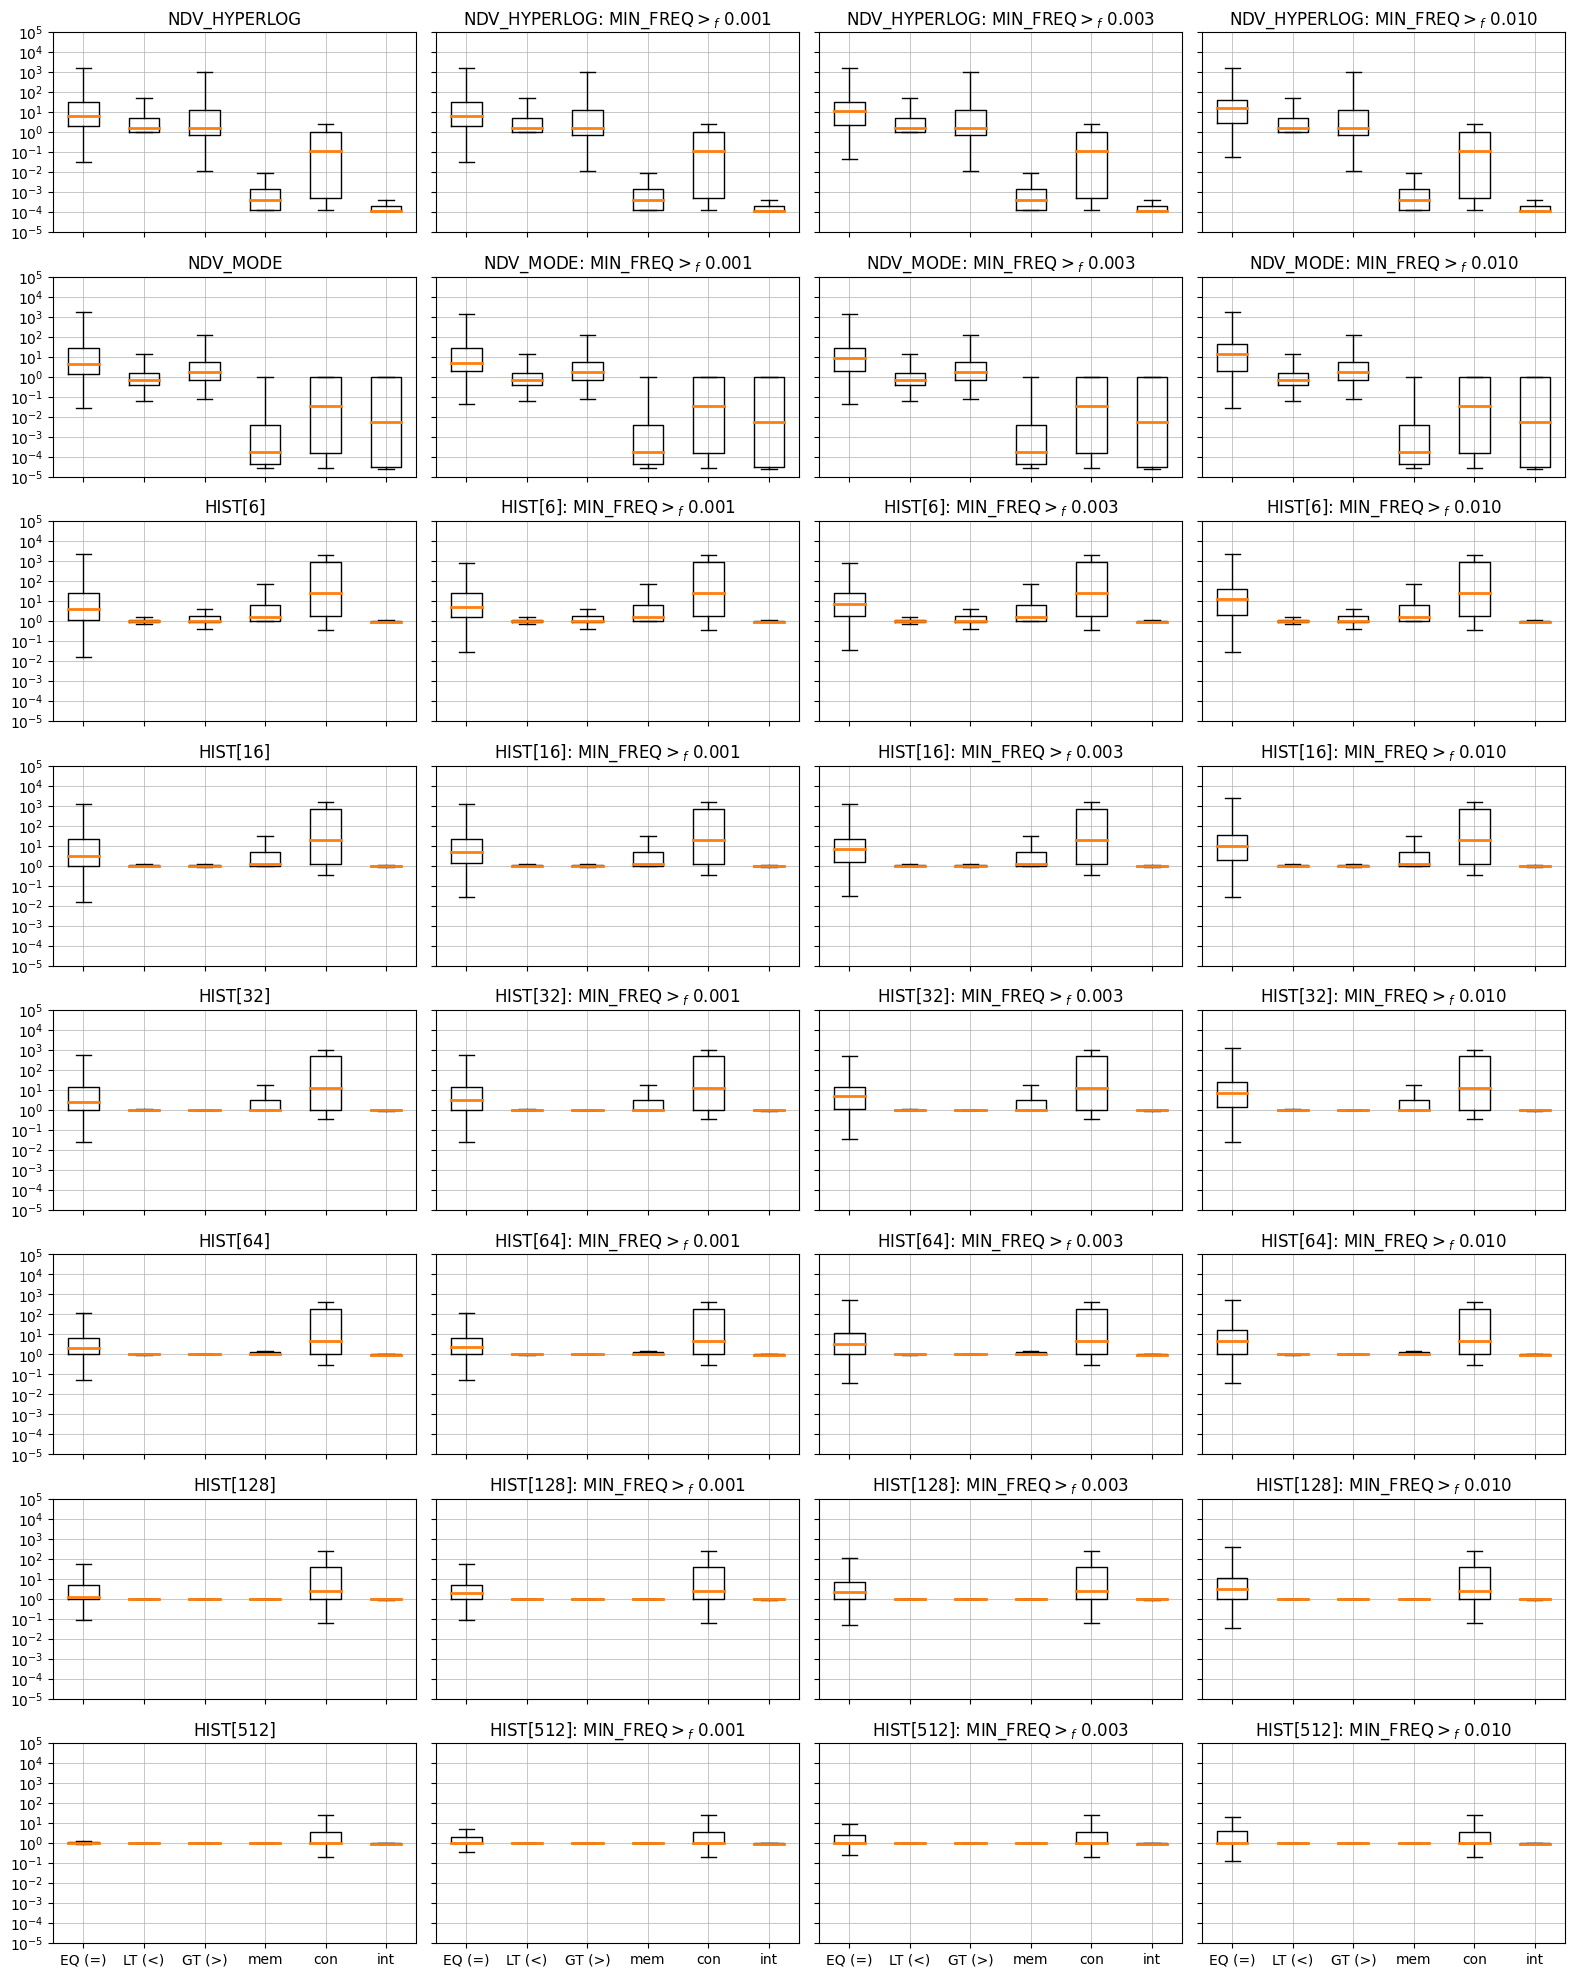

In [107]:
sr = 0.0

data_rows = [
    dr for dr in get_by_settings(prune_strats=tuple([PruneStrat.MIN_FREQ]), sampling_rate=sr)
    if dr.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV)
] + [
    dr for dr in get_by_settings(prune_strats=tuple(), sampling_rate=sr)
    if dr.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV)
]

data_rows.sort(
    key=lambda dr: (
        dr.override_settings["stats_type"].value, 
        dr.override_settings.get("num_histogram_buckets"),
        dr.override_settings.get("prune_params", {"min_freq_threshold": 0})["min_freq_threshold"],
    )
)

all_errs = []
titles = []
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue
        
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        
        collected_errors[operator] = err_series

    all_errs.append(collected_errors)
    ov_sets = datarow.override_settings
    titles.append(
        format_title(
            stats_type=ov_sets["stats_type"], 
            num_hist_bucks=ov_sets.get("num_histogram_buckets"),
            prune_strat=ov_sets["prune_strats"], 
            min_freq_threshold=ov_sets.get("prune_params", {"min_freq_threshold": 0})["min_freq_threshold"],
            short_hist=True
        )
    )

fig = multiple_boxplots(all_errs, titles, ylim=(-5, 5), layout=(len(data_rows)//4, 4), figsize=(16, 20), shareax=True)

# savefig(fig, "all_boxplots_per_operator_max_sampling")
savefig(fig, "prune_min_freq_all_err_impact")

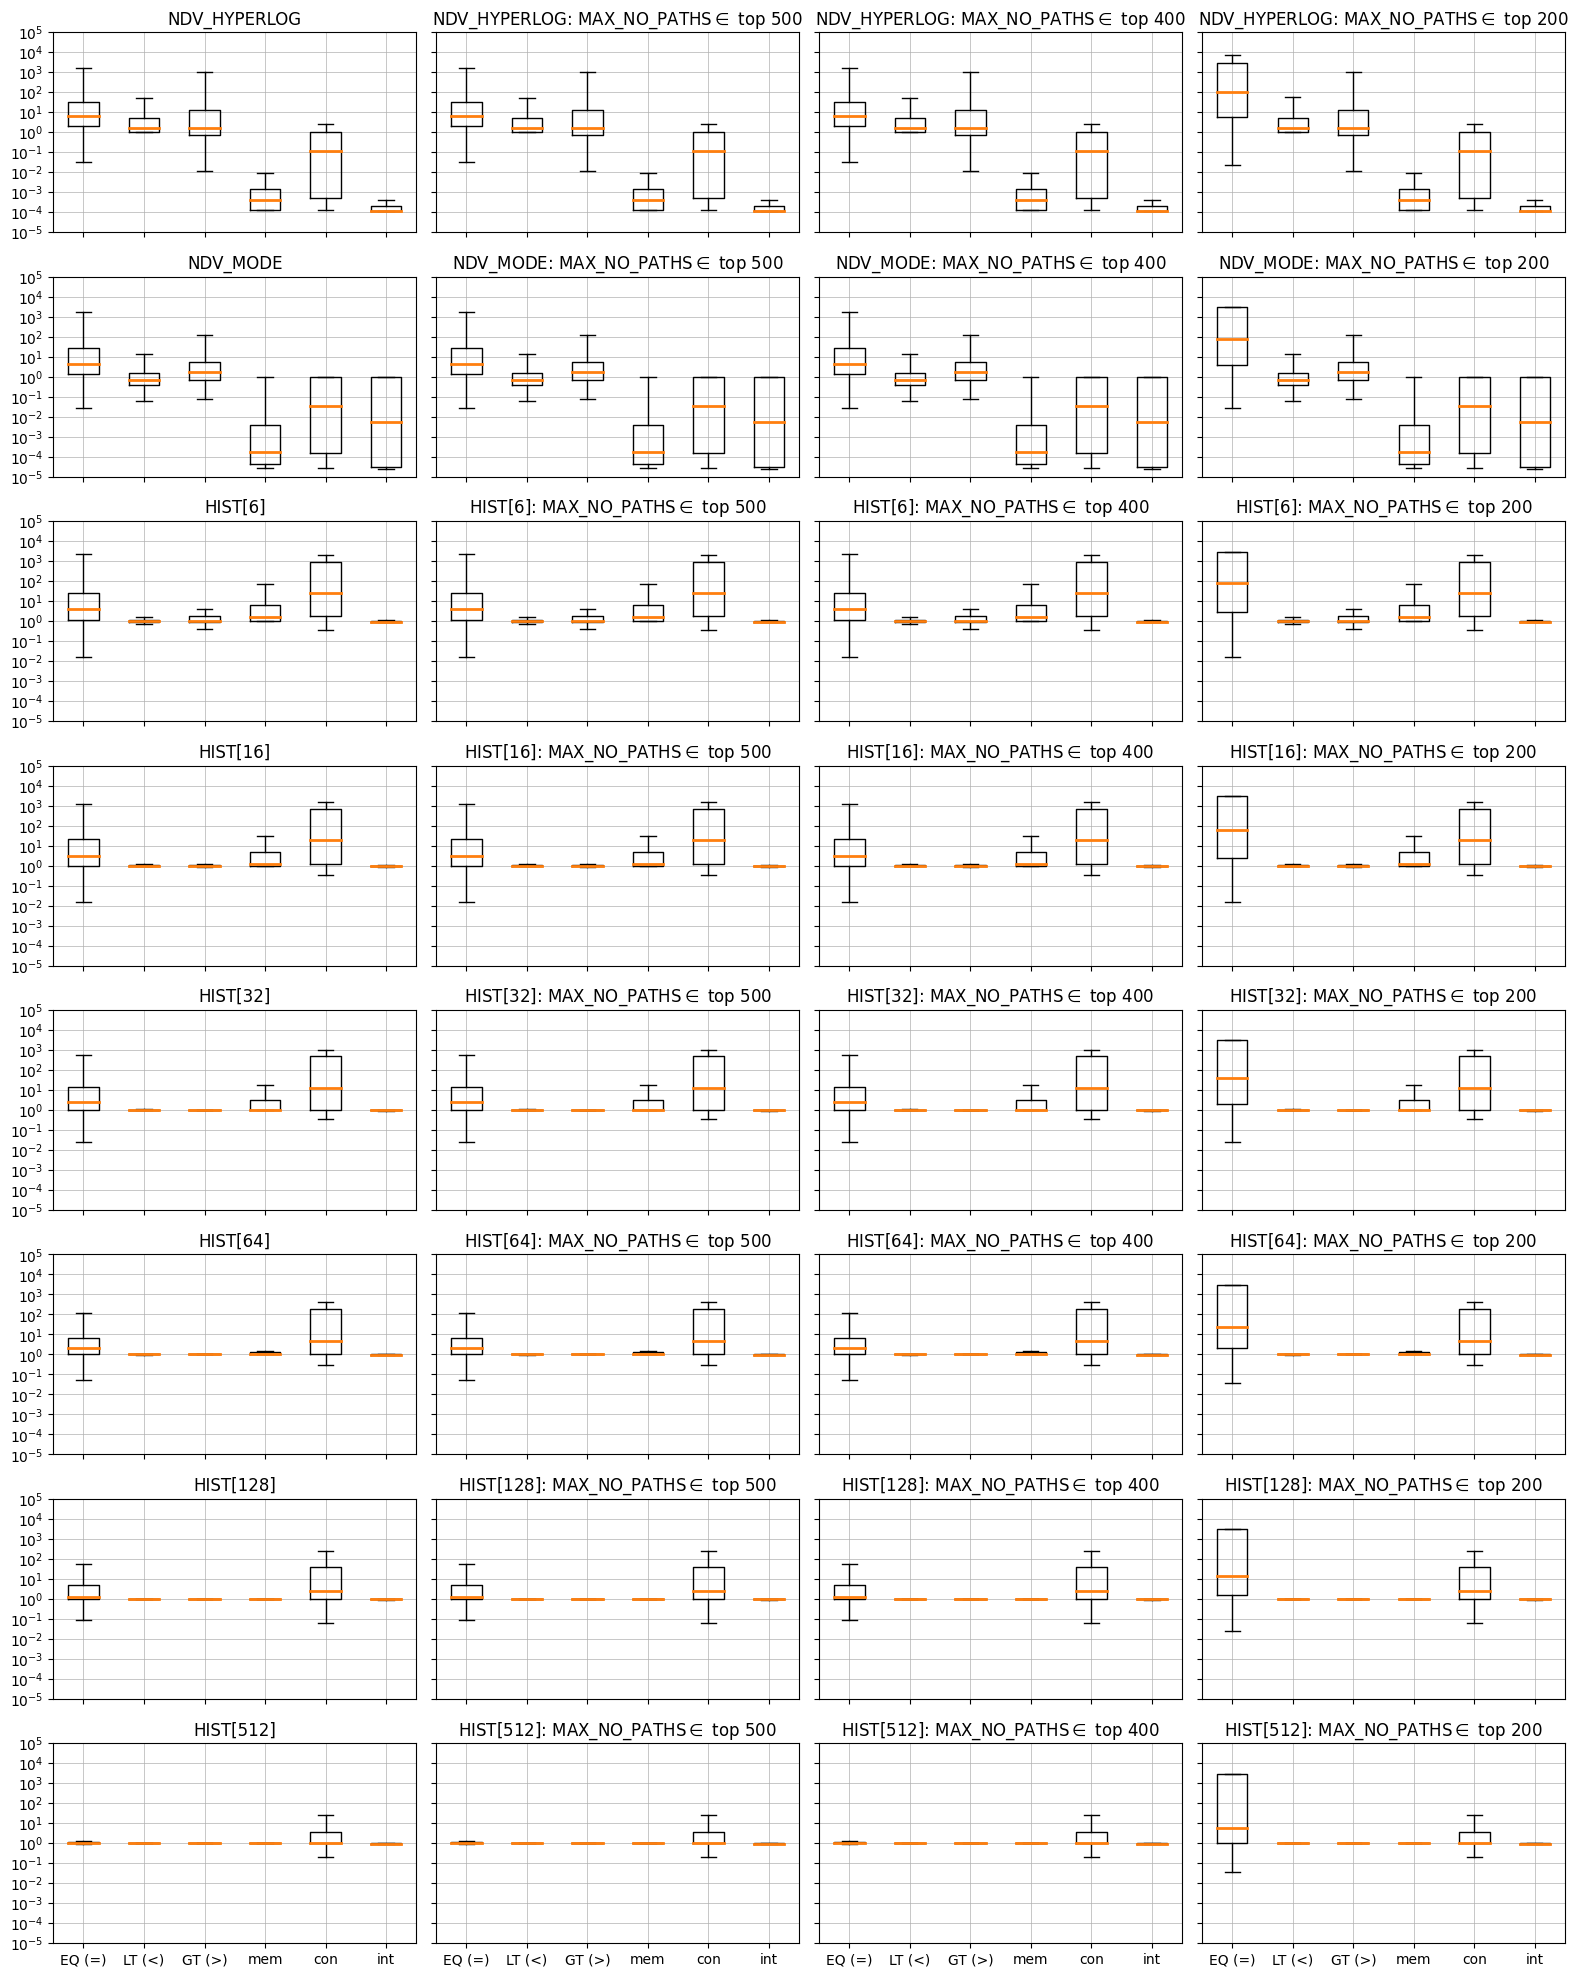

In [108]:
sr = 0.0

data_rows = [
    dr for dr in get_by_settings(prune_strats=tuple([PruneStrat.MAX_NO_PATHS]), sampling_rate=sr)
    if dr.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV)
] + [
    dr for dr in get_by_settings(prune_strats=tuple(), sampling_rate=sr)
    if dr.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV)
]

data_rows.sort(
    key=lambda dr: (
        dr.override_settings["stats_type"].value, 
        dr.override_settings.get("num_histogram_buckets"),
        1000 - dr.override_settings.get("prune_params", {"max_no_paths_threshold": 1000})["max_no_paths_threshold"],
    )
)

all_errs = []
titles = []
for datarow in data_rows:
    test_data = datarow.actual_data

    collected_errors = {}
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue
        
        err_series = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        
        collected_errors[operator] = err_series

    all_errs.append(collected_errors)
    ov_sets = datarow.override_settings
    titles.append(
        format_title(
            stats_type=ov_sets["stats_type"], 
            num_hist_bucks=ov_sets.get("num_histogram_buckets"),
            prune_strat=ov_sets["prune_strats"], 
            max_no_paths_threshold=ov_sets.get("prune_params", {"max_no_paths_threshold": 0})["max_no_paths_threshold"],
            short_hist=True
        )
    )

fig = multiple_boxplots(all_errs, titles, ylim=(-5, 5), layout=(len(data_rows)//4, 4), figsize=(16, 20), shareax=True)

savefig(fig, "prune_max_no_paths_all_err_impact")

### Combined error distributions in a single plot

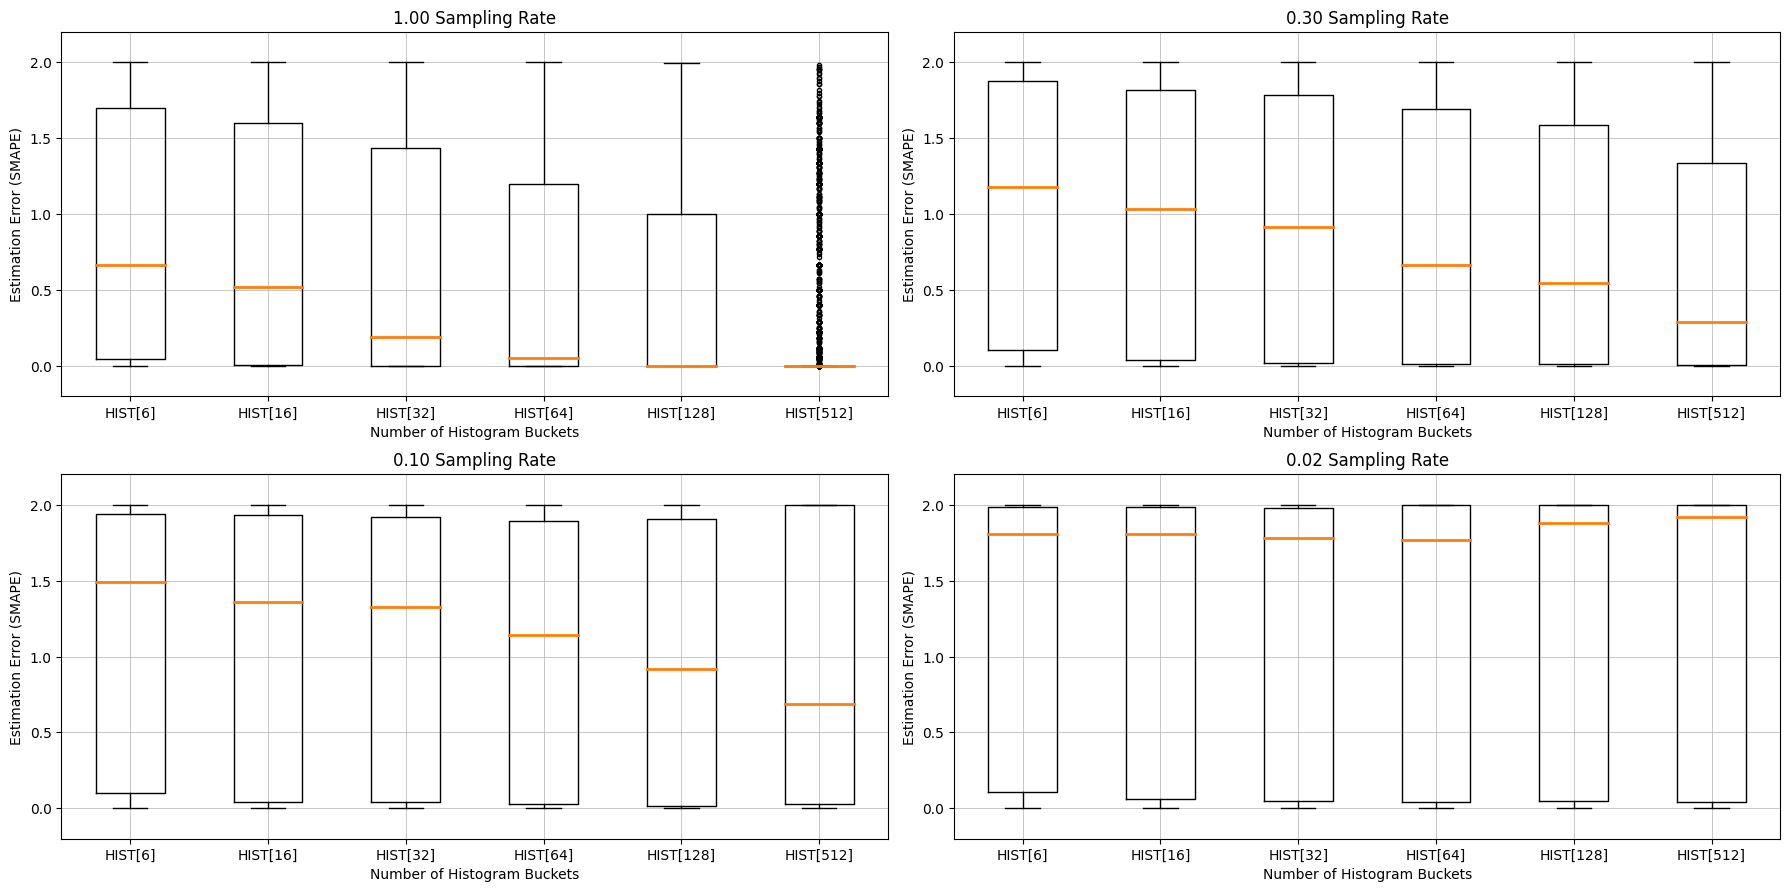

In [114]:
sr = 0.0

all_results, all_titles = [], []
for sr in (0.0, 0.7, 0.9, 0.98):

    data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=sr, stats_type=StatType.HISTOGRAM)
    result = {}
    for datarow in data_rows:
        test_data = datarow.actual_data
        ov_sets = datarow.override_settings

        err_series = pd.Series(dtype=float)
        for operator, op_results in test_data.items():
            if not op_results: continue
            
            op_errors = pd.Series(list(starmap(sym_rel_err, zip(*op_results))))
            # op_errors = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
            err_series = pd.concat([err_series, op_errors])

        title = format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets"), short_hist=True)
        result[title] = err_series


    all_results.append(result)
    all_titles.append(format_title(sampling_rate=sr))

    # fig = boxplot(result, ylim=(-0.2, 2.2), is_log=False, showfliers=True)
    # fig = boxplot(result, ylim=(-5, 5), showfliers=True)   

fig = multiple_boxplots(
    all_results,
    all_titles,
    showfliers=True,
    
    # ylim=(-5, 6),
    ylim=(-0.2, 2.2),
    is_log=False,

    layout=(2,2),
    # shareax=True,
    xlabel="Number of Histogram Buckets",
    ylabel="Estimation Error (SMAPE)",
    # violin=True,
)

# savefig(fig, "histogram_buckets_combined_log_error_per_sample_rate_violin")
# savefig(fig, "histogram_buckets_combined_log_error_per_sample_rate_boxplot")
savefig(fig, "histogram_buckets_combined_sym_error_per_sample_rate_boxplot")


# TODO: Plot overall estimate accuracy for Twitter and then AirBnB datasets

5
eq 3967
lt 875
gt 875
memberof 800
contains 800
overlaps 800
eq 3967
lt 875
gt 875
memberof 800
contains 800
overlaps 800
eq 3967
lt 875
gt 875
memberof 800
contains 800
overlaps 800
eq 3967
lt 875
gt 875
memberof 800
contains 800
overlaps 800
eq 3967
lt 875
gt 875
memberof 800
contains 800
overlaps 800


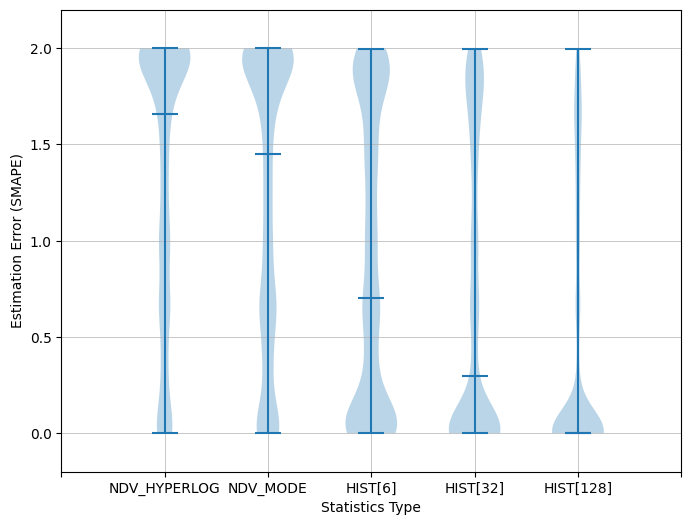

In [124]:
sr = 0.0

incl_arrays = True
only_arrays = False

data_rows = [
    drow for drow in
    get_by_settings(prune_strats=tuple(), sampling_rate=sr)
    if (drow.override_settings["stats_type"] not in (StatType.BASIC, StatType.BASIC_NDV))
        and drow.override_settings.get("num_histogram_buckets", 6) in (6, 32, 128)
]

print(len(data_rows))

# data_rows = get_by_settings(prune_strats=tuple(), sampling_rate=sr, stats_type=StatType.HISTOGRAM)
result = {}
for datarow in data_rows:
    test_data = datarow.actual_data
    ov_sets = datarow.override_settings

    err_series = pd.Series(dtype=float)
    for operator, op_results in test_data.items():
        if not op_results: continue
        if operator in ("exists", "is_null", "is_not_null"): continue

        if only_arrays:
            if operator not in ("memberof", "contains", "overlaps"): 
                continue
        
        if not incl_arrays:
            if operator  in ("memberof", "contains", "overlaps"): 
                continue
        
        op_errors = pd.Series(list(starmap(sym_rel_err, zip(*op_results))))
        # op_errors = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
        # if operator in ("memberof", "contains", "overlaps"):
        #     op_errors = op_errors.repeat(10)

        print(operator, len(op_errors))
        err_series = pd.concat([err_series, op_errors])

    title = format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets"), short_hist=True)
    result[title] = err_series

fig = boxplot(result,
    
    # ylim=(-5, 6),
    ylim=(-0.2, 2.2),
    is_log=False,

    xlabel="Statistics Type",
    ylabel="Estimation Error (SMAPE)",
    # showfliers=True,
    violin=True,
)


# TODO: All these, and put them together either all four or in pairs in the report

if in_file == "training":
    if incl_arrays:
        savefig(fig, "overall_accuracy_w_array_twitter")
    else:
        savefig(fig, "overall_accuracy_no_array_twitter")
    if only_arrays:
        assert(False)
else:
    if only_arrays:
        assert incl_arrays
        savefig(fig, "overall_accuracy_only_array_airbnb")
    elif incl_arrays:
        savefig(fig, "overall_accuracy_w_array_airbnb")
    else:
        savefig(fig, "overall_accuracy_no_array_airbnb")

### Histograms vs Pruning Amount

None
0.001
0.003
0.01


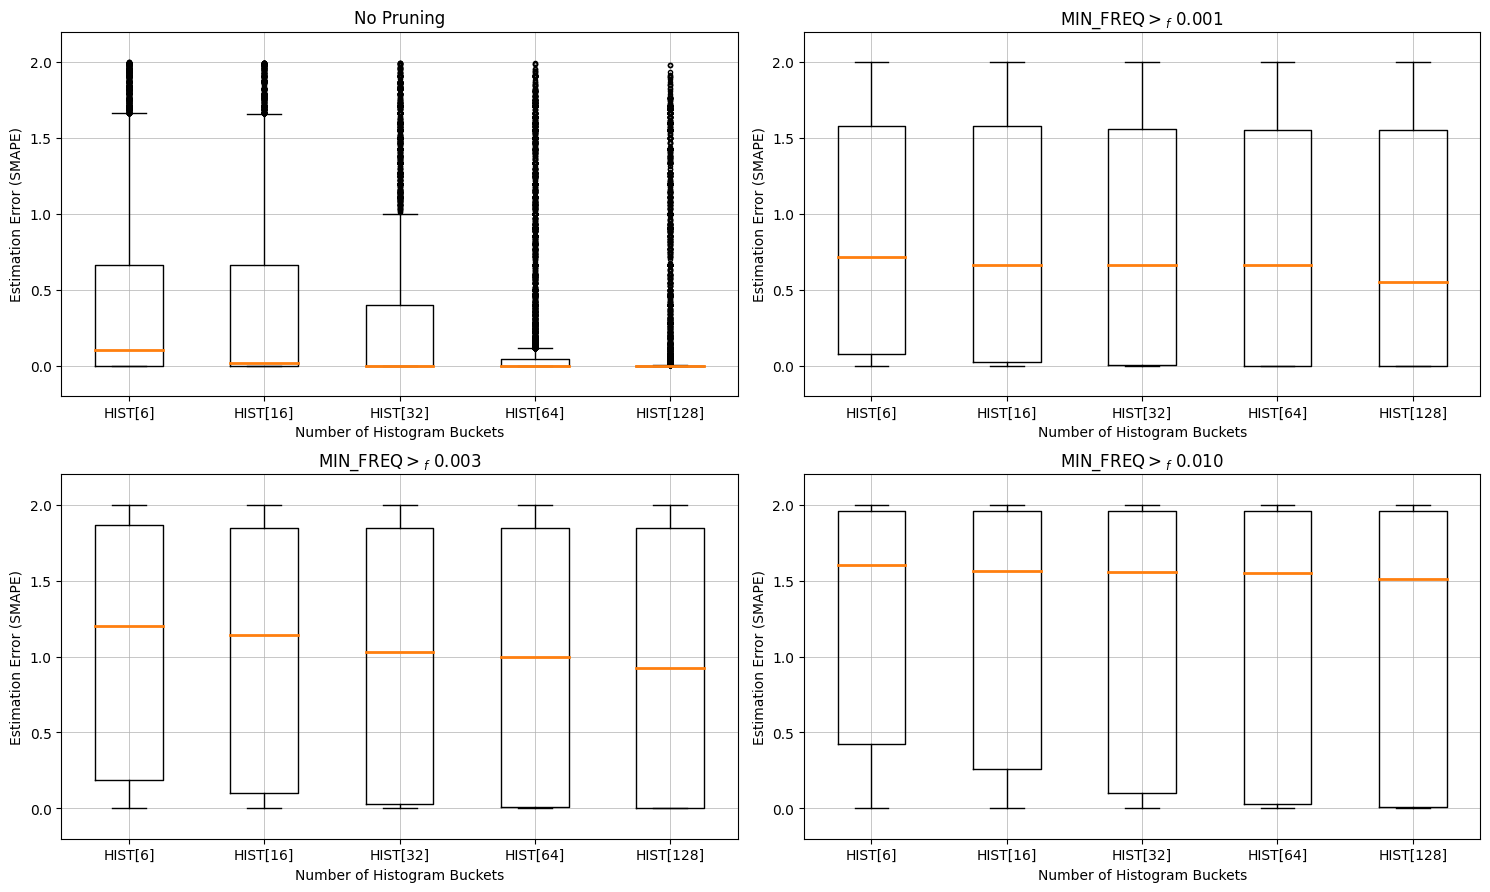

In [ ]:
from itertools import groupby


sr = 0.0

all_results, all_titles = [], []
all_datarows = get_by_settings(prune_strats=tuple([PruneStrat.MIN_FREQ]), sampling_rate=sr, stats_type=StatType.HISTOGRAM)
all_datarows.sort(key=lambda dr: dr.override_settings["prune_params"]["min_freq_threshold"])
groups = [(f, list(group)) for f, group in groupby(all_datarows, key=lambda dr: dr.override_settings["prune_params"]["min_freq_threshold"])]
groups = [(None, get_by_settings(prune_strats=tuple(), sampling_rate=sr, stats_type=StatType.HISTOGRAM))] + groups

for group in groups:

    result = {}
    for datarow in group[1]:
        test_data = datarow.actual_data
        ov_sets = datarow.override_settings

        err_series = pd.Series(dtype=float)
        for operator, op_results in test_data.items():
            if not op_results: continue
            
            op_errors = pd.Series(list(starmap(sym_rel_err, zip(*op_results))))
            # op_errors = pd.Series(list(starmap(log_rel_err, zip(*op_results))))
            err_series = pd.concat([err_series, op_errors])

        title = format_title(stats_type=ov_sets["stats_type"], num_hist_bucks=ov_sets.get("num_histogram_buckets"), short_hist=True)
        result[title] = err_series

    
    print(group[0])

    all_results.append(result)
    all_titles.append(format_title(prune_strat=PruneStrat.MIN_FREQ, min_freq_threshold=group[0]) if group[0] else "No Pruning")


    # fig = boxplot(result, ylim=(-0.2, 2.2), is_log=False, showfliers=True)
    # fig = boxplot(result, ylim=(-5, 5), showfliers=True)   

fig = multiple_boxplots(
    all_results,
    all_titles,
    showfliers=True,
    
    # ylim=(-5, 6),
    ylim=(-0.2, 2.2),
    is_log=False,

    layout=(2, 2),
    # figsize=(5, 8),
    
    # shareax=True,
    xlabel="Number of Histogram Buckets",
    ylabel="Estimation Error (SMAPE)",
    # violin=True,
)

savefig(fig, "histogram_num_buckets_impact_when_pruning")


### BASIC_NDV vs NDV_HYPERLOG

In [ ]:
# Get basic and hyperlog ndv stats and interleave them in pairs
basic_ndvs = get_by_settings(stats_type=StatType.BASIC_NDV, prune_strats=tuple())
hyperlog_ndvs = get_by_settings(stats_type=StatType.NDV_HYPERLOG, prune_strats=tuple())
data_rows = []
for bn, hn in zip(basic_ndvs, hyperlog_ndvs):
    data_rows.append(bn)
    data_rows.append(hn)

### Error Comparison

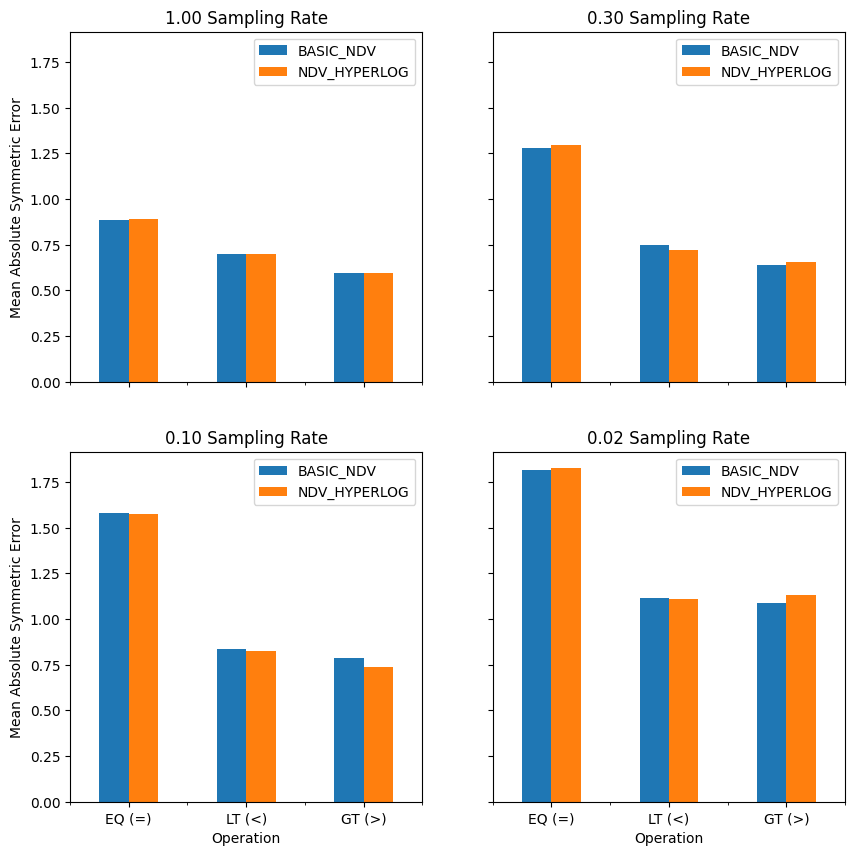

In [ ]:
all_errs = []
titles = []

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
for i, (bn, hn) in enumerate(zip(basic_ndvs, hyperlog_ndvs)):
    result = {}

    for config_case in (bn, hn):
        errors = {}
        for operator, op_results in config_case.actual_data.items():
            if not op_results: continue
            if operator in ("exists", "is_null", "is_not_null"): continue # NDV does not contribute to these
            
            errors[translate_label(operator)] = SMARE(*op_results)

        ov_sets = config_case.override_settings
        # title = format_title(stats_type=ov_sets["stats_type"], sampling_rate=ov_sets["sampling_rate"])
        title = format_title(stats_type=ov_sets["stats_type"])
        
        result[title] = errors

    df = pd.DataFrame(result)
    df.plot(
        ax=axes[i//2, i%2],
        kind="bar", title=format_title(sampling_rate=ov_sets["sampling_rate"]),
        xlabel="Operation",
        ylabel="Mean Absolute Symmetric Error",
        rot=0,
    )

# savefig(fig, "basic_hyperlog_ndv_error_difference")

### Memory Usage Comparison

KeyError: 'stats_creation_max_mem_use'

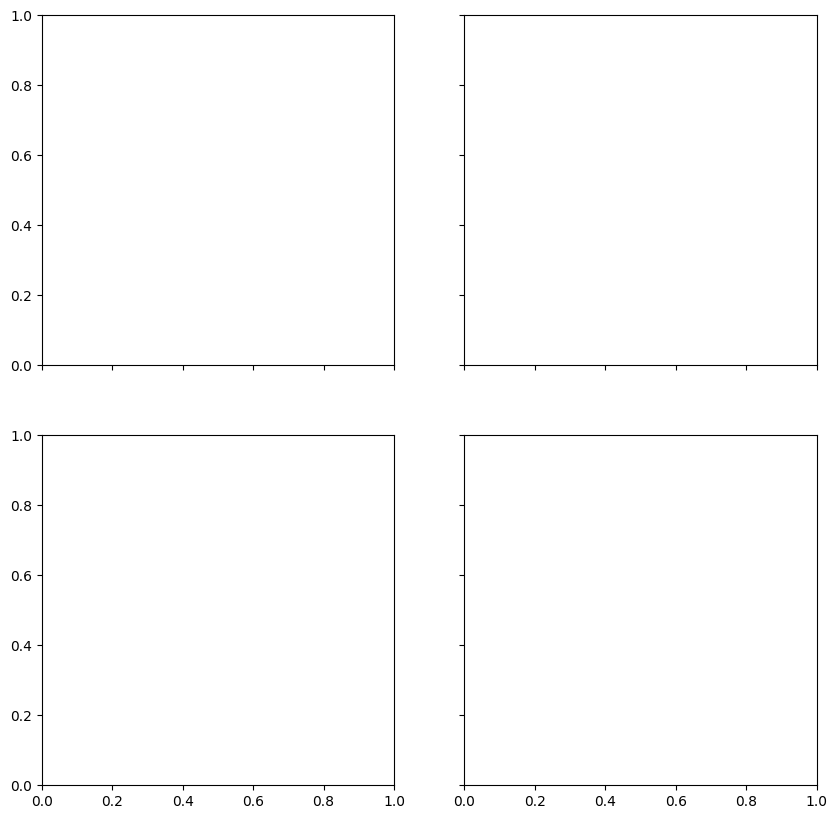

In [ ]:
all_errs = []
titles = []

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
for i, (bn, hn) in enumerate(zip(basic_ndvs, hyperlog_ndvs)):
    result = {}

    for config_case in (bn, hn):
        errors = {}
        errors["Program Memory Footprint"] = config_case.meta_data["stats_creation_max_mem_use"]
        errors["Subroutine Memory Footprint"] = config_case.meta_data["stats_creation_max_mem_use_isolated"]

        ov_sets = config_case.override_settings
        title = format_title(stats_type=ov_sets["stats_type"])
        
        result[title] = errors

    df = pd.DataFrame(result)
    ax = df.plot(
        ax=axes[i//2, i%2],
        kind="bar", title=format_title(sampling_rate=ov_sets["sampling_rate"]),
        # xlabel="Operation",
        ylabel="Memory Used During Creation (in MB)",
        rot=10,
        logy=True
    )
    # ax.yaxis.set_major_formatter(lambda x, _pos: )
    ax.yaxis.set_major_formatter(lambda x, _pos: str(x) + "MB")

savefig(fig, "basic_hyperlog_ndv_memory_difference")